KFの類似度(0.9) 0.6404422368210223
YSの類似度(0.9) 0.7032526838647652


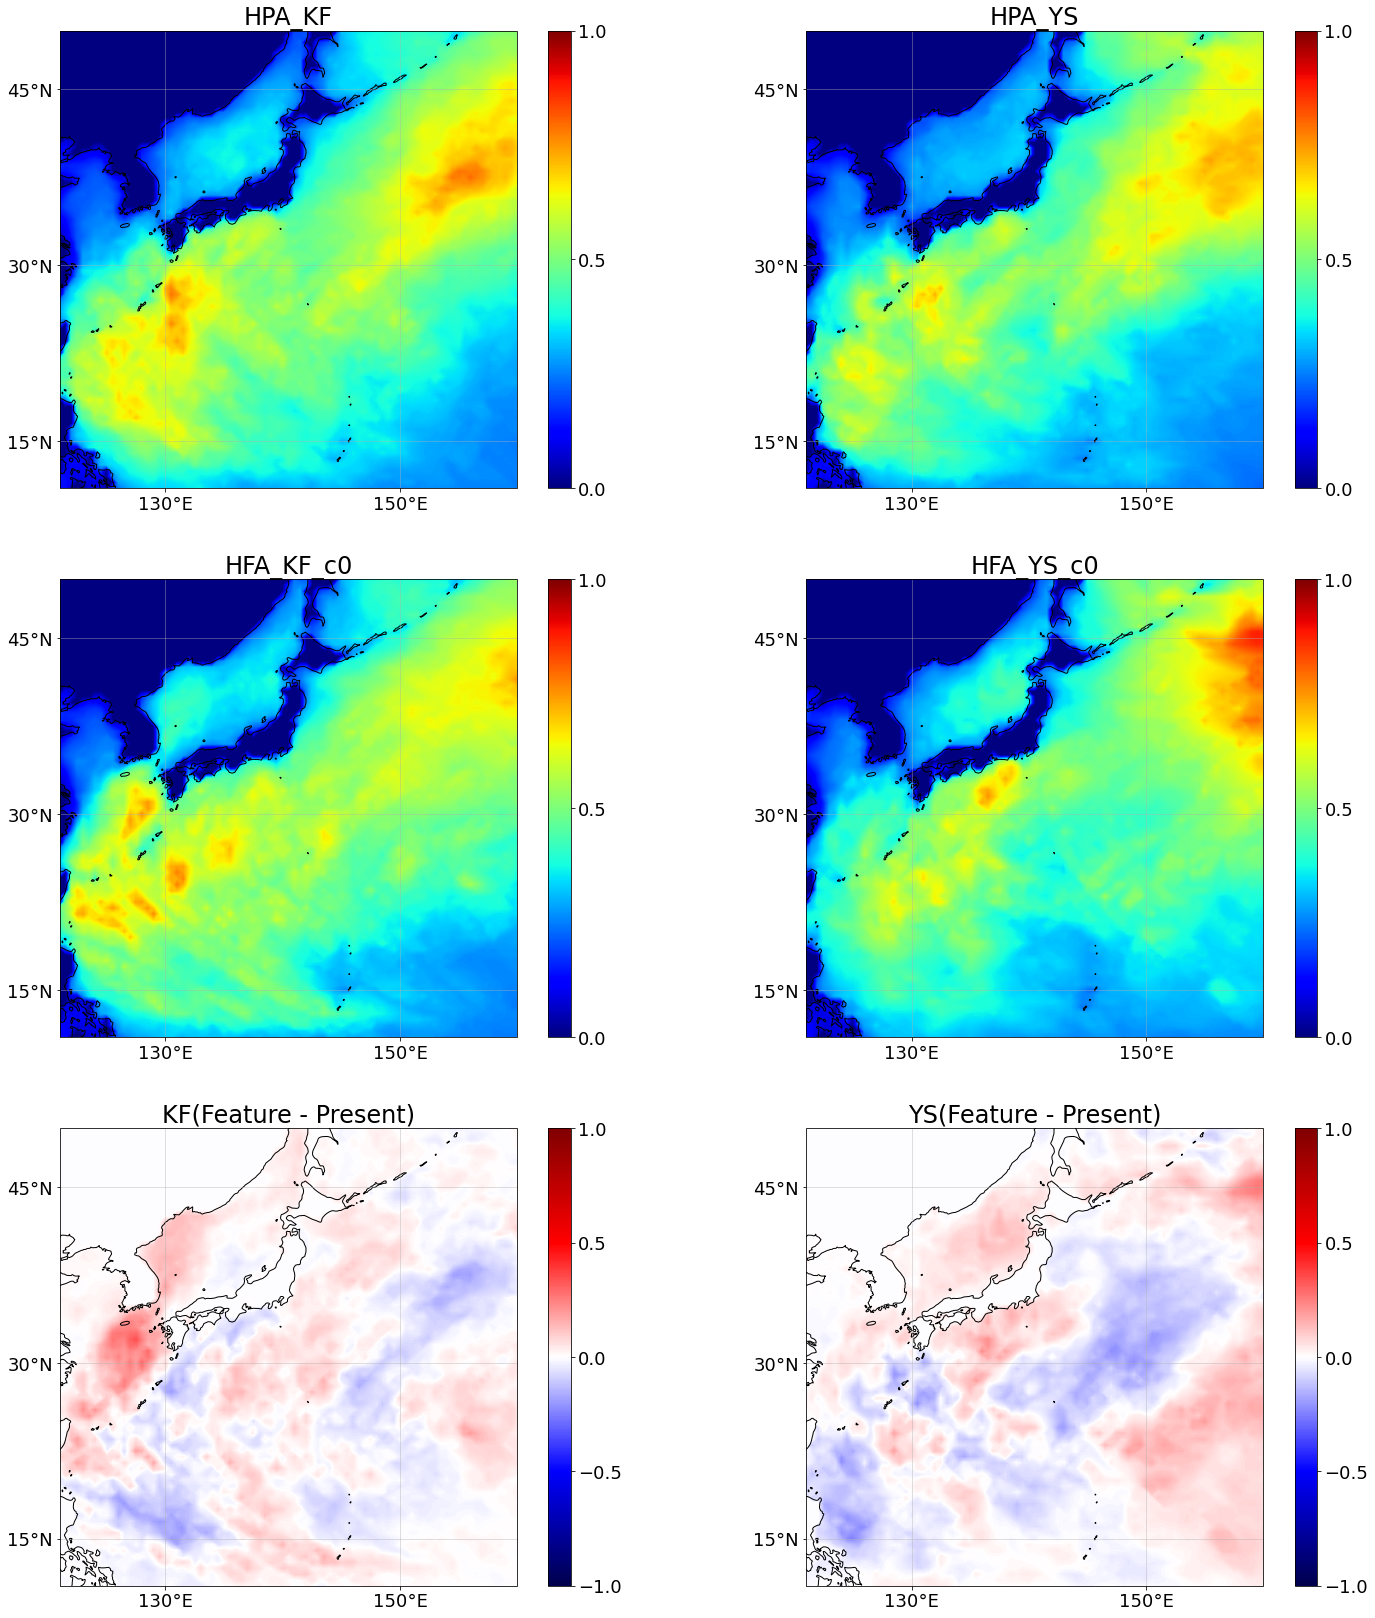

KFの類似度(0.95) 0.7035731453292742
YSの類似度(0.95) 0.7301714468835122


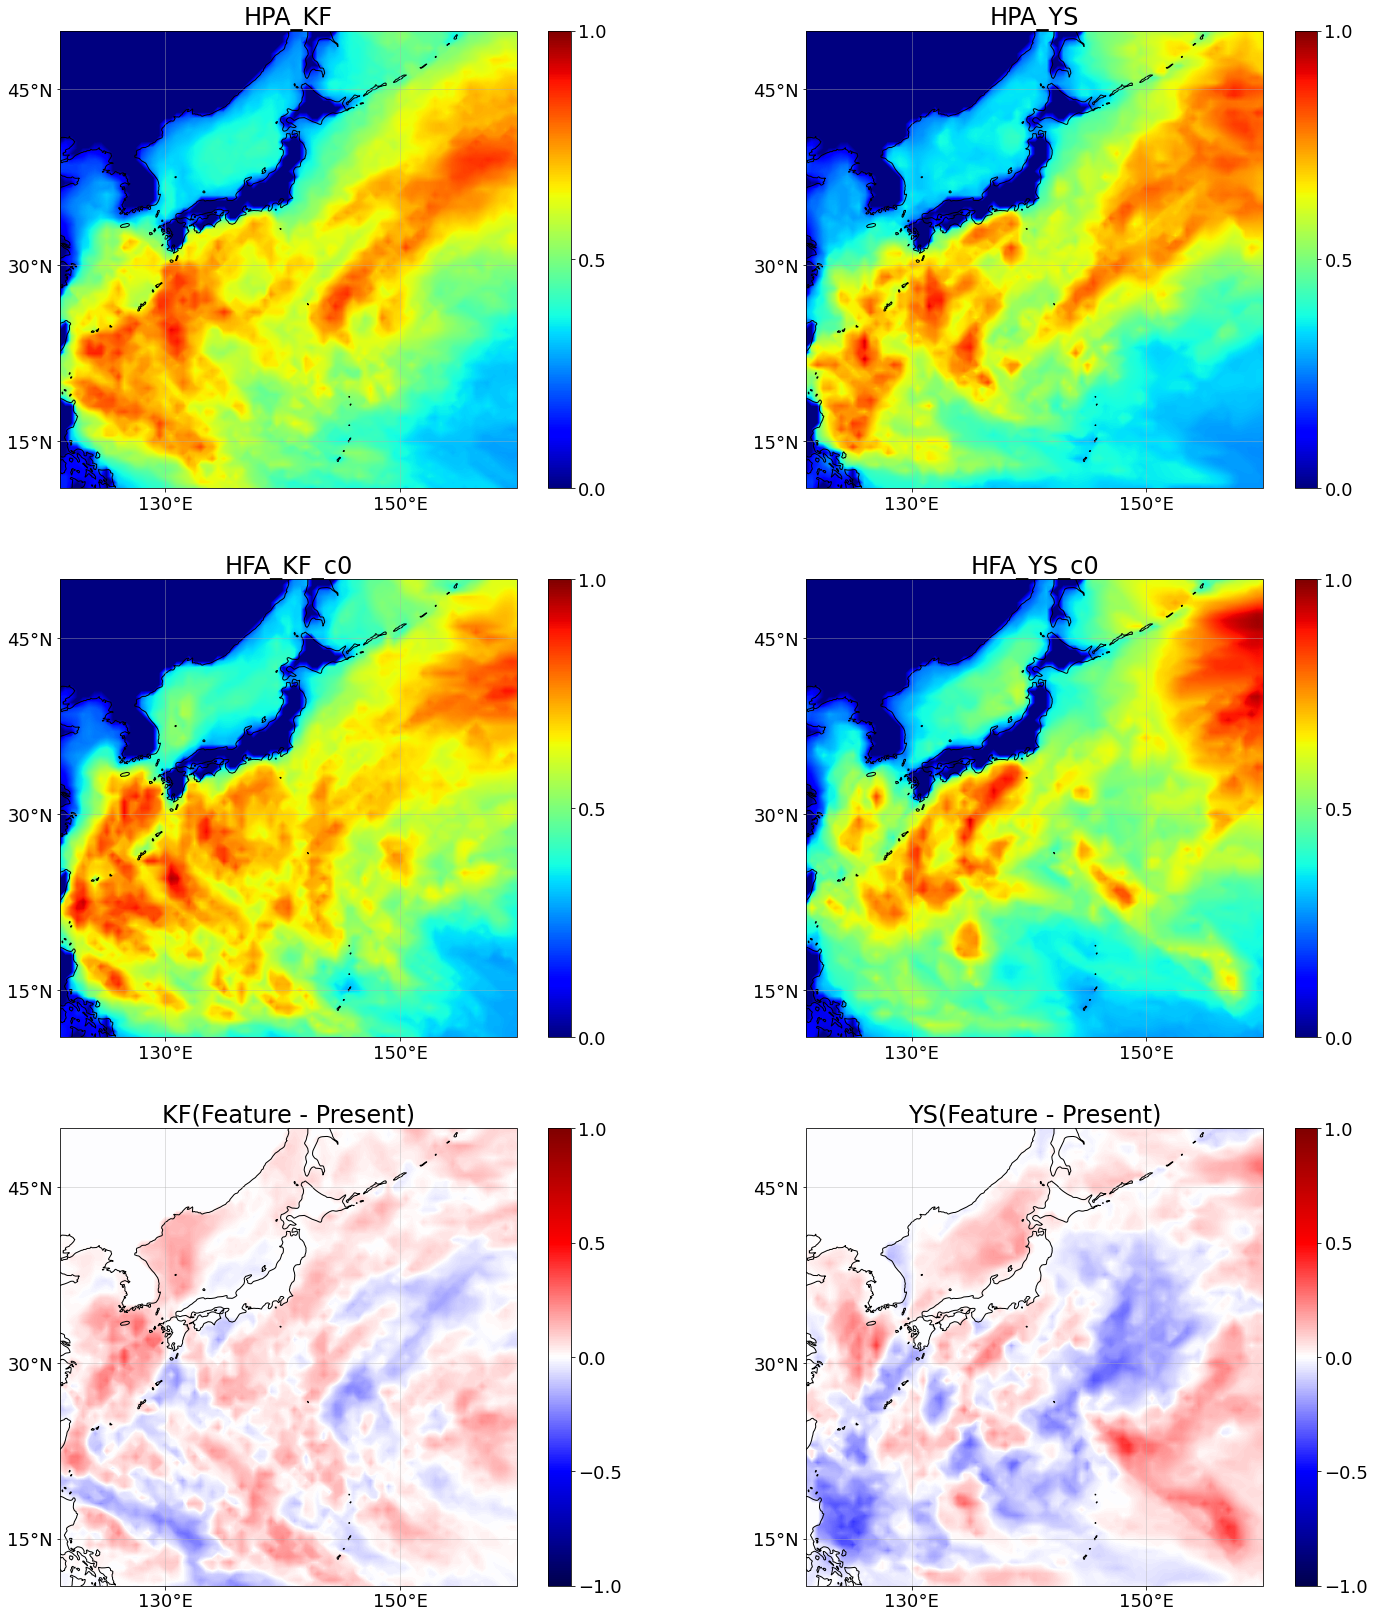

KFの類似度(0.99) 0.6694439993590771
YSの類似度(0.99) 0.7646210543182183


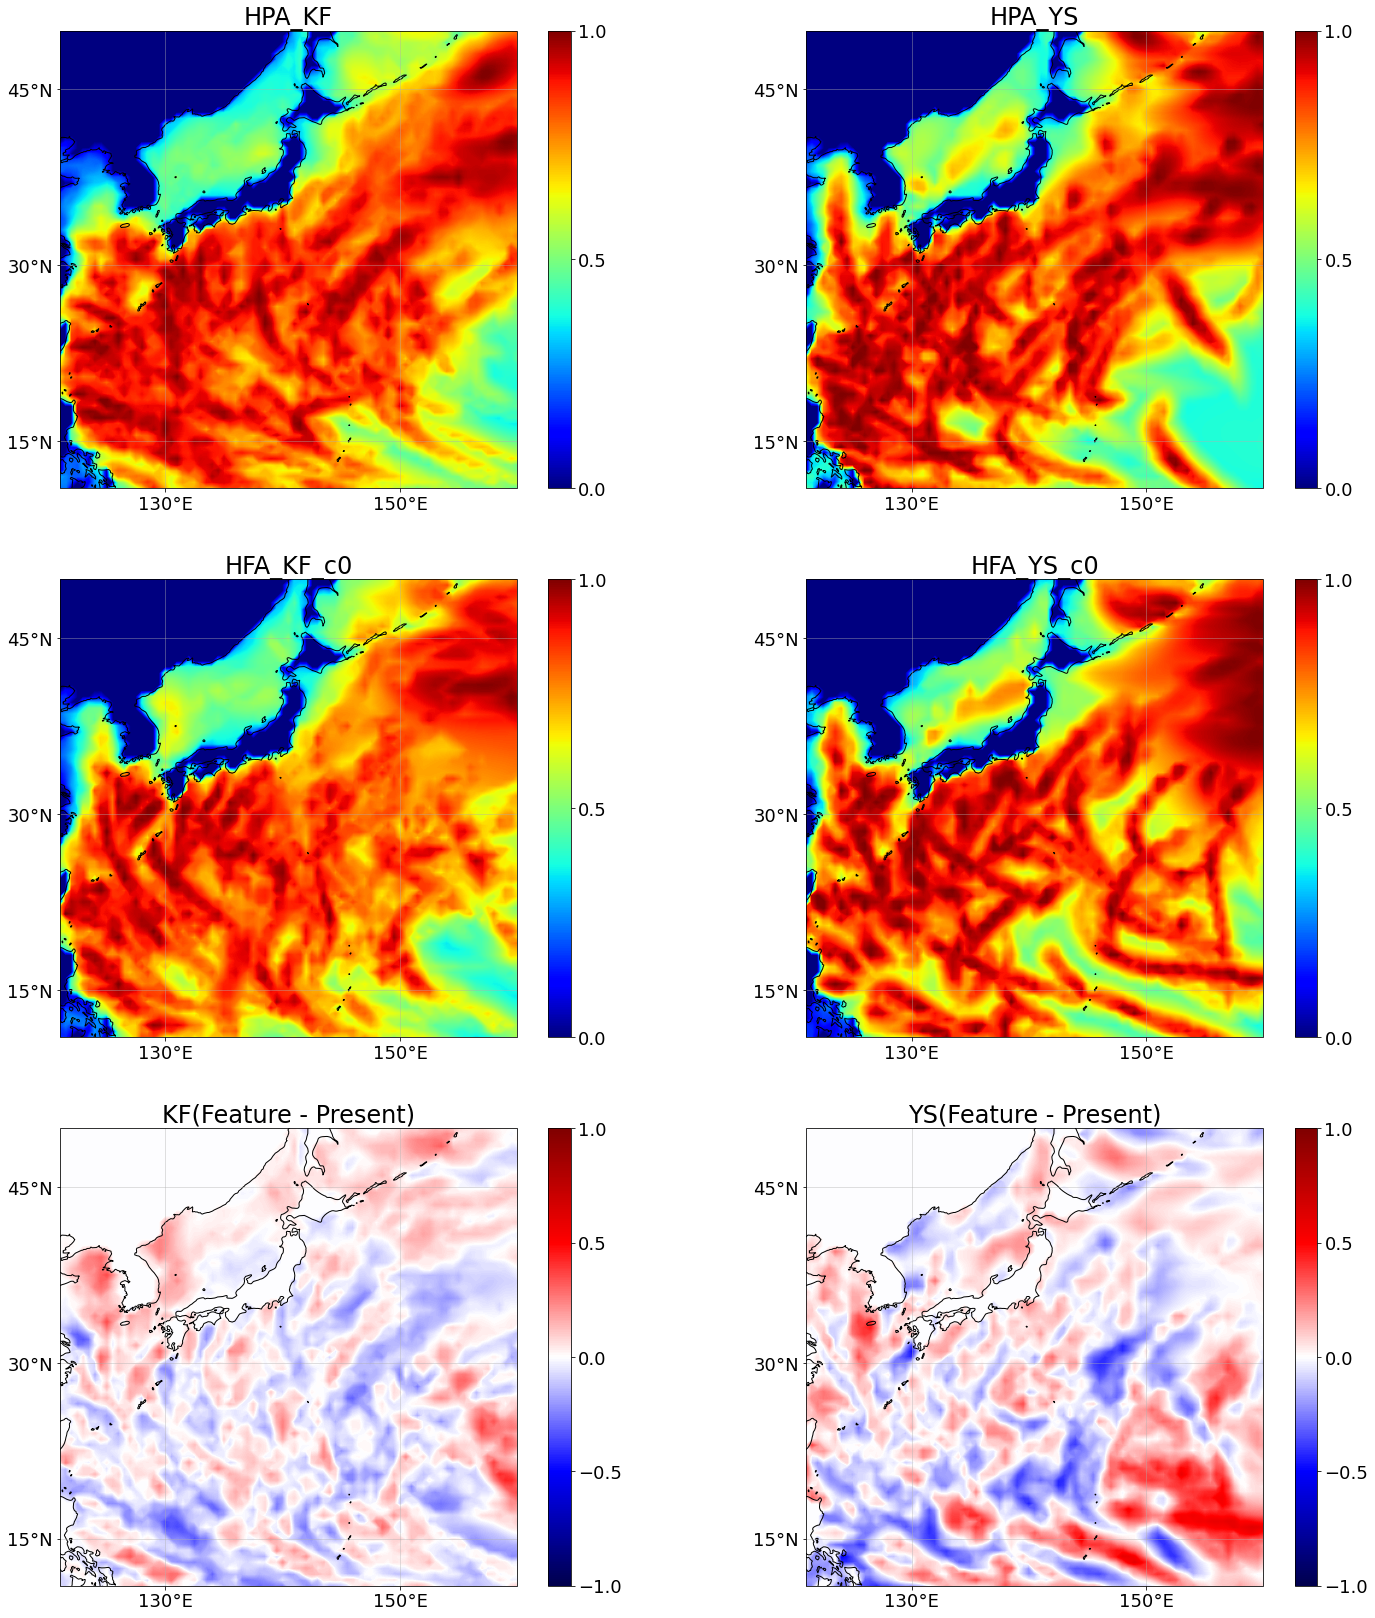

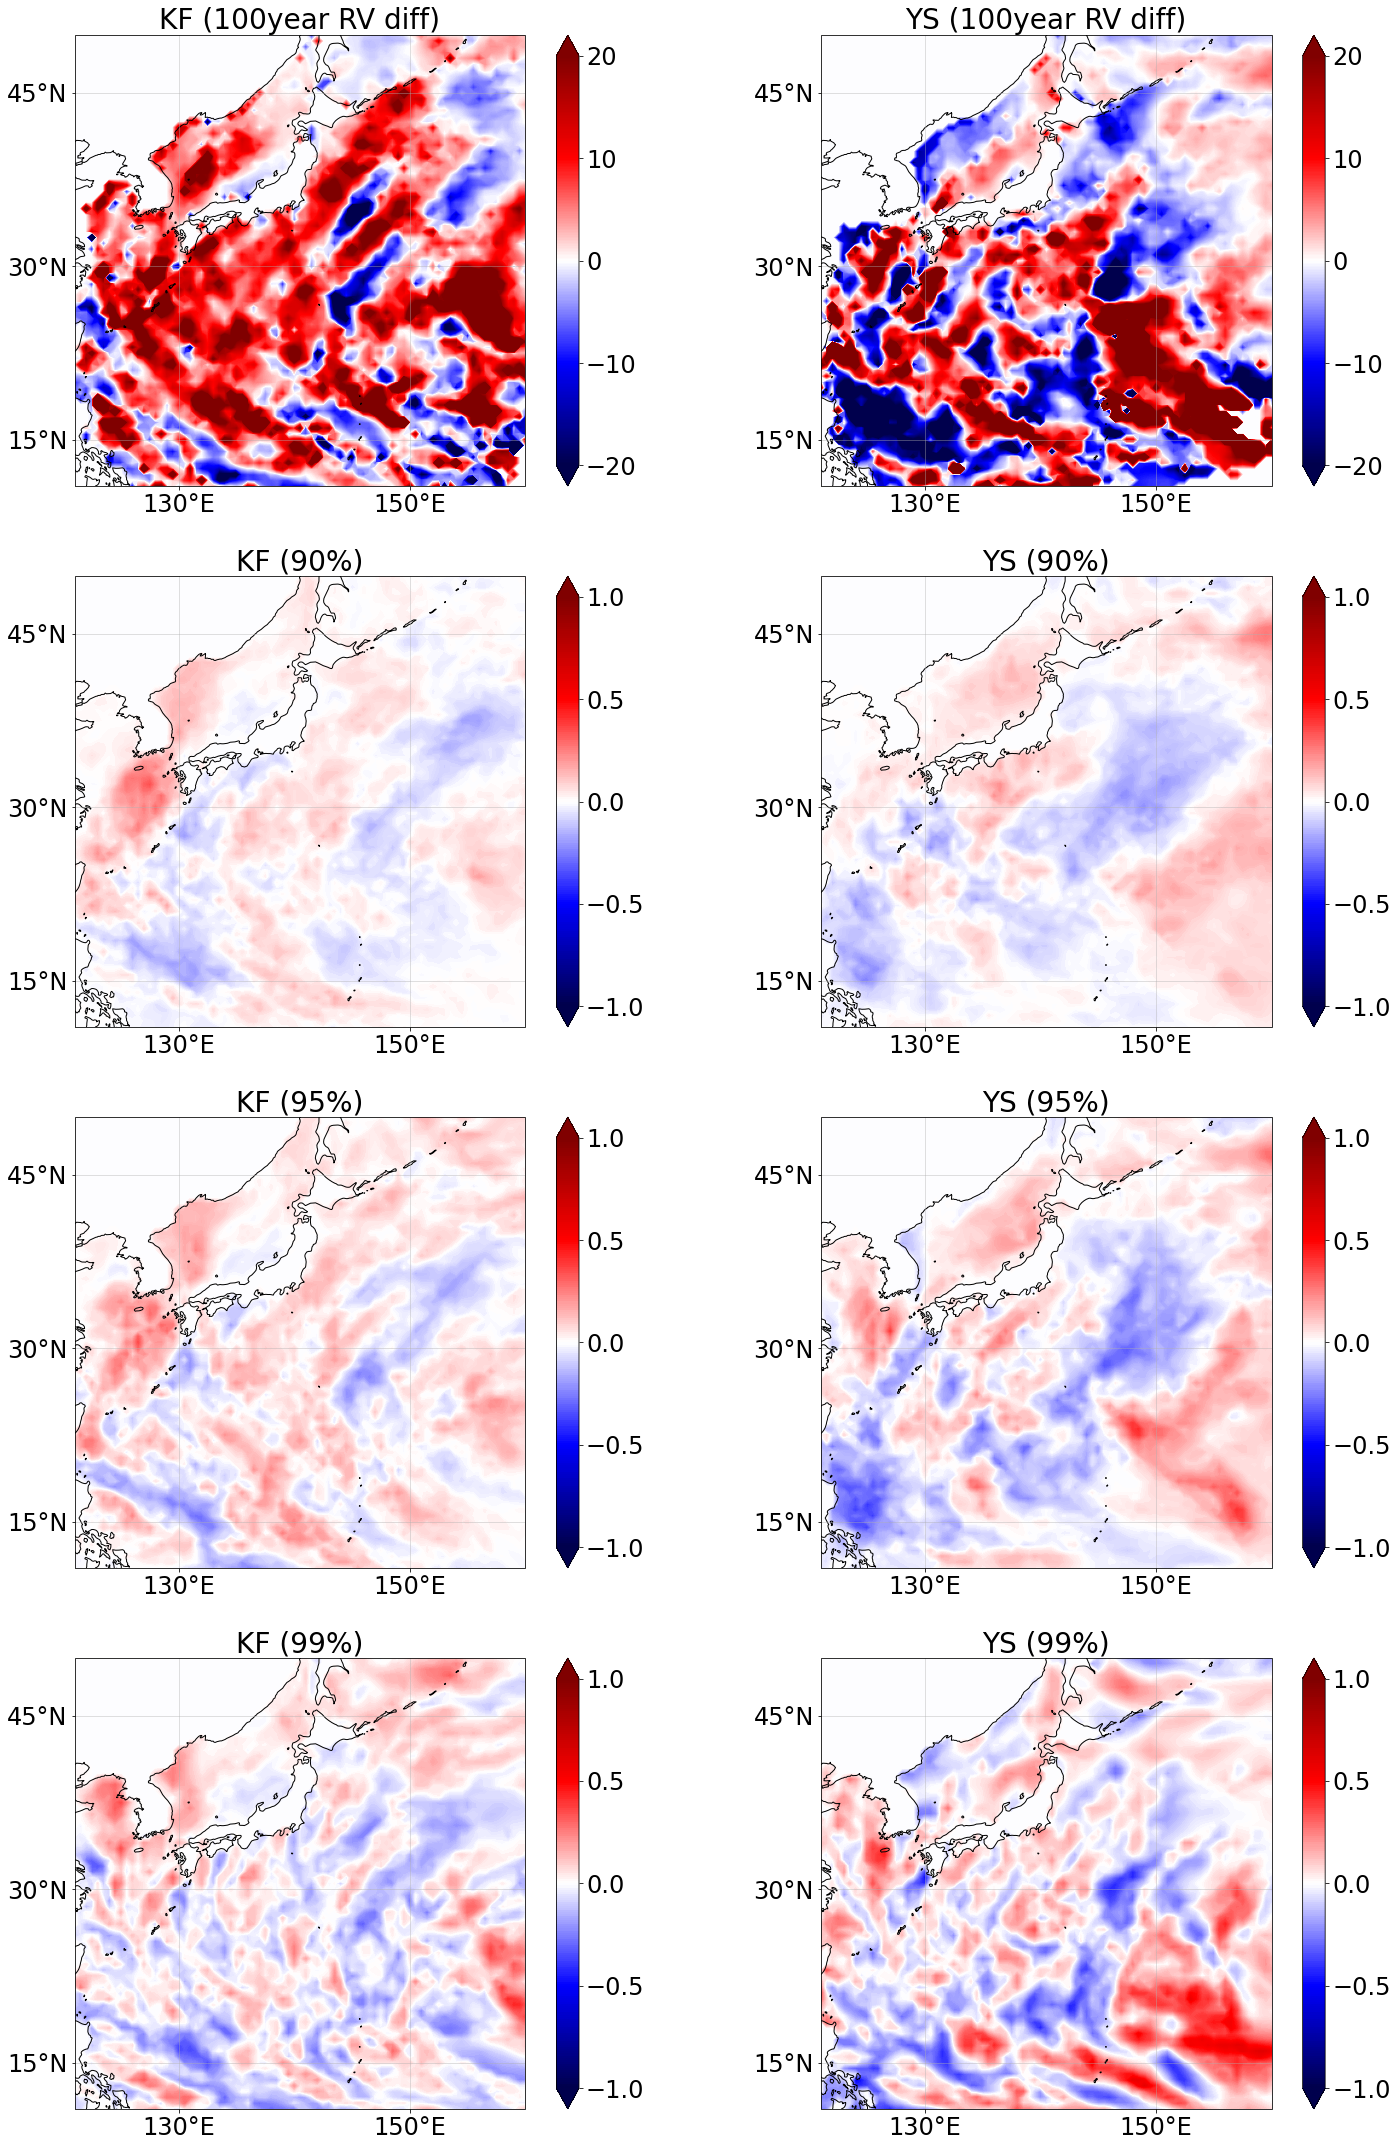

In [28]:
"""
Exposureの90%, 95%, 99%点を現在と将来で算出し, 差を比較する.
この空間分布が100yRVの分布と類似していることが重要.
類似度を定量化するために100yRV*Exposureが負になっている地点数も計算する.
"""
import csv
import numpy as np
from csv import reader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import copy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker

with open('../lats.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lats = list(csv_reader)
with open('../lons.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    lons = list(csv_reader)

for i in range(79):
    for j in range(79):
        lats[i][j] = float(lats[i][j])
        lons[i][j] = float(lons[i][j])

# 100yRV
DATA_F = []
DATA_P = []

with open('../100y_vizualize(100)(thr=6)/RV_csv/HFA_KF.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    DATA_F.append(list(csv_reader))
with open('../100y_vizualize(100)(thr=6)/RV_csv/HPA_KF.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    DATA_P.append(list(csv_reader))
with open('../100y_vizualize(100)(thr=6)/RV_csv/HFA_YS.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    DATA_F.append(list(csv_reader))
with open('../100y_vizualize(100)(thr=6)/RV_csv/HPA_YS.csv', 'r') as csv_file:
    csv_reader = reader(csv_file)
    DATA_P.append(list(csv_reader))

# str → float
for i in range(79):
    for j in range(79):
        for k in range(2):
            DATA_F[k][i][j] = float(DATA_F[k][i][j])
            DATA_P[k][i][j] = float(DATA_P[k][i][j])

# list → np-array
for i in range(2):
    DATA_F[i] = np.array(DATA_F[i])
    DATA_P[i] = np.array(DATA_P[i])

PERCENT_EXPOSURE = []
MODEL = ['HPA_KF', 'HFA_KF_c0', 'HPA_YS', 'HFA_YS_c0']
for PERCENT in [0.9, 0.95, 0.99]:
    fig = plt.figure(figsize=(20, 24))
    for model_num in range(2):
        MAP_LIST = []  # Exposureの分布を格納. [0]:現在, [1]:将来
        for time in range(2):
            model = MODEL[model_num * 2 + time]
            with open('../Ex_csv/' + model + '_max.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                STM = list(csv_reader)

            # STMを探索し, Exposureを算出
            STM_DATA = [[] for _ in range(len(STM[0]))]
            for j in range(len(STM[0])):
                mx = 0
                LOC_IDX = 0  # 場所を表すindex
                for k in range(79 * 79):
                    if mx < float(STM[k][j]):
                        mx = float(STM[k][j])
                        LOC_IDX = k
                STM_DATA[j] = [mx, LOC_IDX]
                for k in range(79 * 79):
                    STM[k][j] = float(STM[k][j]) / mx

            # 各点でのExposureを書き出し
            with open('../Ex_csv/' + model + '_ex_ratio.csv', 'w') as file:
                writer = csv.writer(file, lineterminator='\n')
                writer.writerows(STM)
            # [STMの大きさ, 場所index] * STMの個数 を書き出し
            with open('../Ex_csv/' + model + '_STM.csv', 'w') as file:
                writer = csv.writer(file, lineterminator='\n')
                writer.writerows(STM_DATA)

            # ここまでで現在/将来のExposureが算出されている
            MAP = np.zeros((79, 79))
            per = int(len(STM[0]) * PERCENT)  # %点を計算
            for i in range(79 * 79):
                MAP[i // 79][i % 79] = sorted(STM[i])[per]
            MAP_LIST.append(MAP)
            levels = np.arange(0, 1.001, 0.001)
            cmap = copy.copy(mpl.cm.get_cmap("jet"))
            ax = fig.add_subplot(3, 2, model_num + time * 2 + 1, projection=ccrs.PlateCarree())
            a = plt.contourf(lons, lats, MAP, levels=levels, transform=ccrs.PlateCarree(), cmap=cmap)
            c_bar = plt.colorbar(a, ticks=[0, 0.5, 1])
            c_bar.ax.tick_params(labelsize=18)
            ax.axes.tick_params(labelsize=18)
            ax.set_title(model, fontsize=24)
            # 以下テンプレ
            c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
            ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
            ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
            lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
            lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.yaxis.set_major_formatter(lat_formatter)
            ax.grid()
            ax.coastlines()
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
            gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
            gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線
        # F - P    
        levels = np.arange(-1, 1.001, 0.001)
        cmap = copy.copy(mpl.cm.get_cmap("seismic"))
        ax = fig.add_subplot(3, 2, 5 + model_num, projection=ccrs.PlateCarree())
        a = plt.contourf(lons, lats, MAP_LIST[1] - MAP_LIST[0], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap)
        c_bar = plt.colorbar(a, ticks=[-1, -0.5, 0, 0.5, 1])
        c_bar.ax.tick_params(labelsize=18)
        ax.axes.tick_params(labelsize=18)
        ax.set_title(model[4:6] + "(Feature - Present)", fontsize=24)
        # 以下テンプレ
        c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
        ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
        ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
        lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
        lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.grid()
        ax.coastlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
        gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
        gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線

        # 100yRVとの類似度合いの定量化
        print(model[4:6] + "の類似度(" + str(PERCENT) + ')', len(np.where((DATA_F[model_num] - DATA_P[model_num]) * (MAP_LIST[1] - MAP_LIST[0]) >= 0)[0]) / (79*79))
        PERCENT_EXPOSURE.append(MAP_LIST[1] - MAP_LIST[0])
    fig.subplots_adjust(left=0.05, right=1.0, bottom=0.05, top=0.95) #この1行を入れる
    plt.savefig('../img/changes_of_exposure_' + str(int(PERCENT*100)) + '.png')
    plt.show()

fig = plt.figure(figsize=(20, 32))
MODEL = ['KF', 'YS']
for i in range(2):
    levels = np.arange(-20, 20.01, 0.1)
    cmap = copy.copy(mpl.cm.get_cmap("seismic"))
    ax = fig.add_subplot(4, 2, i + 1, projection=ccrs.PlateCarree())
    a = plt.contourf(lons, lats, DATA_F[i] - DATA_P[i], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
    c_bar = plt.colorbar(a, ticks=[-20, -10, 0, 10, 20])
    c_bar.ax.tick_params(labelsize=24)
    ax.axes.tick_params(labelsize=24)
    ax.set_title(MODEL[i] + ' (100year RV diff)', fontsize=28)
    c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
    ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
    ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
    lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
    lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.grid()
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
    gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
    gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線

for i in range(3):
    per = [0.9, 0.95, 0.99][i]
    for j in range(2):
        levels = np.arange(-1, 1.001, 0.01)
        ax = fig.add_subplot(4, 2, 3 + j + 2 * i, projection=ccrs.PlateCarree())
        a = plt.contourf(lons, lats, PERCENT_EXPOSURE[j + 2 * i], levels=levels, transform=ccrs.PlateCarree(), cmap=cmap, extend='both')
        c_bar = plt.colorbar(a, ticks=[-1, -0.5, 0, 0.5, 1])
        c_bar.ax.tick_params(labelsize=24)
        ax.axes.tick_params(labelsize=24)
        ax.set_title(MODEL[j] + ' (' + str(int(per * 100)) + '%)', fontsize=28)
        c_bar.ax.yaxis.set_minor_locator(ticker.NullLocator())
        ax.set_xticks([130,150], crs=ccrs.PlateCarree()) # gridを引く経度を指定 360にすると0Wが出ない
        ax.set_yticks([15, 30, 45], crs=ccrs.PlateCarree()) # gridを引く緯度を指定
        lon_formatter = LongitudeFormatter(zero_direction_label=True) # 経度
        lat_formatter = LatitudeFormatter() # 緯度。formatを指定することも可能
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.grid()
        ax.coastlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5) # 経度線・緯度線ラベルを無効
        gl.xlocator = ticker.FixedLocator([130, 150]) # 経度線
        gl.ylocator = ticker.FixedLocator([15, 30, 45]) # 緯度線

fig.subplots_adjust(left=0.05, right=1.0, bottom=0.05, top=0.95) #この1行を入れる
plt.savefig('../img/changes_of_exposure.png')
plt.show()